##OzBench et al.

OzBench, M.; Regenauer-Lieb, K.; Stegman, D. R.; Morra, G.; Farrington, R.; Hale, A.; May, D. A.; Freeman, J.; Bourgouin, L.; Mühlhaus, H. & Moresi, L. A model comparison study of large-scale mantle-lithosphere dynamics driven by subduction.
		Physics of the Earth and Planetary Interiors, 2008, 171, 224-234

In [25]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os
import time

In [2]:
dim = 2

In [3]:
# create mesh objects
#elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("linear","constant"), 
#                                         elementRes=(96,48,96), 
#                                           minCoord=(-2.,0., 0.), 
#                                           maxCoord=(6.,1.0, 9.)  )


elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("linear","constant"), 
                                         elementRes=(96,48), 
                                           minCoord=(-2.,0.), 
                                           maxCoord=(6.,1.0)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [4]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )



In [5]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [6]:
#Boundary conditions

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]


# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

##Geometry setup

In [7]:
#Polygons with more than 3 vertices seem to be crashing atm.

slabupper = np.array([(1.2,1.), (3.4,1.),(3.4,0.975), (1.2,0.975),(1.02,0.925),(1.02,0.95)])
slabcore = np.array([(1.2,0.975), (3.4,0.975),(3.4,0.925), (1.2,0.925),(1.02,0.875),(1.02,0.925)])
slablower = np.array([(1.2,0.925), (3.4,0.925),(3.4,0.9), (1.2,0.9),(1.02,0.85),(1.02,0.875)])


#slab = np.array([(1.2,1.),(1.2,0.975), (3.4,1.)])

upper = fn.shape.Polygon(slabupper )
core = fn.shape.Polygon(slabcore)
lower = fn.shape.Polygon(slablower)

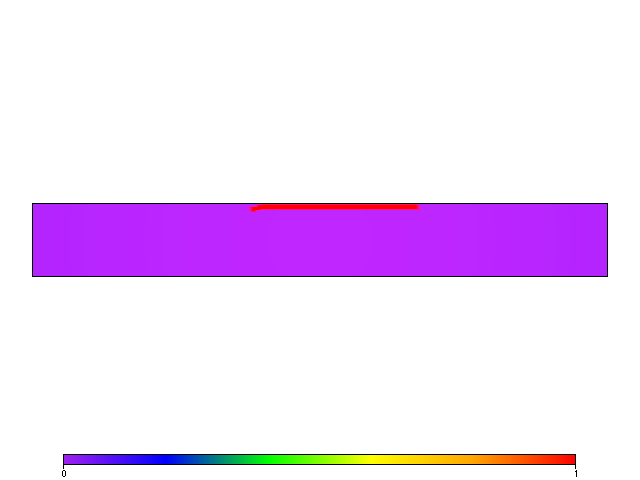

In [8]:
figA = plt.Figure()
figA.Surface(upper | core, linearMesh)
figA.show()

In [9]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20 )
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )


# Lets initialise the 'materialVariable' data to represent two different materials. 
uppermantleIndex = 0
lowermantleIndex = 4

upperslabIndex = 1
coreslabIndex = 2
lowerslabIndex = 3

# Set the material to heavy everywhere via the numpy array
materialVariable.data[:] = uppermantleIndex

In [10]:
for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    if gSwarm.particleCoordinates.data[particleID][1] < 0.4:
        materialVariable.data[particleID] =  lowermantleIndex 
    elif upper.evaluate(tuple(gSwarm.particleCoordinates.data[particleID])):
        materialVariable.data[particleID] =  upperslabIndex
    elif core.evaluate(tuple(gSwarm.particleCoordinates.data[particleID])):
        materialVariable.data[particleID] =  coreslabIndex
    elif lower.evaluate(tuple(gSwarm.particleCoordinates.data[particleID])):
        materialVariable.data[particleID] =  lowerslabIndex

In [11]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
fig1.show()

##Rheology 

In [12]:
#Ozbench VonMises uses "strain rate field", presumably this refers to second invariant

secinv = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

cohesion = 0.06
vonMises = cohesion/(secinv) #extra factor to account for underworld second invariant form

upperlowervisc = fn.exception.SafeMaths(fn.misc.min(vonMises, 200))

In [13]:
#
linearviscosityMapFn = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = {uppermantleIndex:1.,lowermantleIndex:100., upperslabIndex:200., coreslabIndex:2.0e4, lowerslabIndex:200.} )

viscosityMapFn = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = {uppermantleIndex:1.,lowermantleIndex:100., upperslabIndex:vonMises, coreslabIndex:2.0e4, lowerslabIndex:vonMises} )

densityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {uppermantleIndex:0.,lowermantleIndex:0., upperslabIndex:1., coreslabIndex:1., lowerslabIndex:1.} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, -1.0 )

# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading

buoyancyFn = gravity*densityMapFn

##Stokes system and Solver

In [16]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(linearviscosityMapFn), 
                              bodyForceFn=buoyancyFn )

In [17]:
solver = uw.systems.Solver(stokesPIC)

In [18]:
solver.solve(nonLinearIterate=True)

In [20]:
# Setup the Stokes system again, now with full viscosity
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn)

In [21]:
# Create advector objects to advect the swarms. We specify second order integration.
advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2)

In [22]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0

timevals = []
vrmsvals = []

In [23]:
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

In [28]:
advector.get_max_dt()

160.37945367316948

In [34]:
# create integral to get diff 

start = time.clock()
while step<100:
    #stokesPIC2.solve(nonLinearIterate=True)
    solver.solve(nonLinearIterate=True)
    dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect swarm using this timestep size
    advector.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(time)
    Rms = rms()
    #f_o.write((2*'%-15s ' + '\n') % (realtime,Rms))
    if step % 10 == 0:
        print 'step =',step, 'rms', Rms

step = 10 rms 2.52206438137e-06
step = 20 rms 2.84854455923e-06
step = 30 rms 5.27801898787e-06
step = 40 rms 6.03533917542e-06
step = 50 rms 5.00259732017e-06
step = 60 rms 5.52227865147e-06
step = 70 rms 4.81447850201e-06
step = 80 rms 4.15995826667e-06
step = 90 rms 5.83005002984e-06
step = 100 rms 4.82639628644e-06


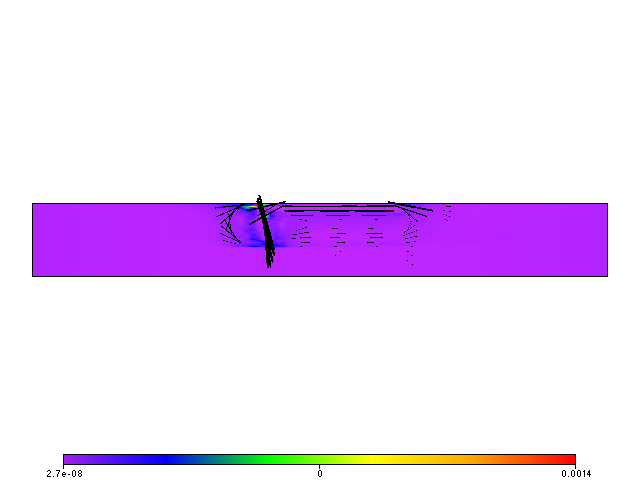

In [56]:
# visualise
fig1 = plt.Figure()
fig1.Surface(secinv, elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
fig1.VectorArrows(velocityField, linearMesh,arrowHeadSize=1., lengthScale=4e4 )
fig1.save_database('test_pol.gldb')
fig1.show()